**part1**
1. I will use regex to keep letters, numbers, and special characters that may meaningful, such as '&', '-', '%', '?', '!', remove words "yeah". I will use cross-validation to better reflect the stability of the model.

In [1]:
import pandas as pd
import nltk
import regex as re
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.preprocessing import normalize
import random
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, linear_kernel

In [2]:
# Load dataset
df = pd.read_csv("dataset.tsv", sep="\t")

print(df.head())

                            artist_name         track_name  release_date  \
0                                loving  the not real lake          2016   
1                               incubus    into the summer          2019   
2                             reignwolf           hardcore          2016   
3                  tedeschi trucks band             anyhow          2016   
4  lukas nelson and promise of the real  if i started over          2017   

   genre                                             lyrics      topic  
0   rock  awake know go see time clear world mirror worl...       dark  
1   rock  shouldn summer pretty build spill ready overfl...  lifestyle  
2  blues  lose deep catch breath think say try break wal...    sadness  
3  blues  run bitter taste take rest feel anchor soul pl...    sadness  
4  blues  think think different set apart sober mind sym...       dark  


In [3]:
# concatenate all the informations for one song in df['all_text']
df['artist_name'] = df['artist_name'].fillna('').str.lower()
df['track_name'] = df['track_name'].fillna('').str.lower()
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year.fillna(0).astype(int).astype(str)
df['genre'] = df['genre'].fillna('').str.lower()
df['lyrics'] = df['lyrics'].fillna('').str.lower()
df['all_text'] = df['artist_name'] +  ' ' + df['track_name'] + ' '  + df['release_date'] + ' ' + df['genre'] + ' '+ df['lyrics']
print(df['all_text'])

0       loving the not real lake 1970 rock awake know ...
1       incubus into the summer 1970 rock shouldn summ...
2       reignwolf hardcore 1970 blues lose deep catch ...
3       tedeschi trucks band anyhow 1970 blues run bit...
4       lukas nelson and promise of the real if i star...
                              ...                        
1495    ra ra riot absolutely 1970 rock year absolutel...
1496    mat kearney face to face 1970 rock breakthroug...
1497    owane born in space 1970 jazz look look right ...
1498    nappy roots blowin' trees 1970 hip hop nappy r...
1499    skillet stars 1970 rock speak word life begin ...
Name: all_text, Length: 1500, dtype: object


2. **Preprocessing**

Lowercasing: set lower case for all the words.

Regex: use regex libaray rather than re to keep words in other language.

Stopwords: using stopwords from NLTK libaray and keep the meaningful words like 'not', 'but'.

Word tokenize: use word_tokenize to split the text to words.

Lemmatization: Lemmatization processes words more accurately. It is beneficial for the subsequent sentiment analysis.

In [94]:
# Download required NLTK data
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
# Init tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) - {'not', 'no', 'but', 'very'}

# POS mapping function
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Preprocessing function
def preprocess_text(text):
    text = text.lower()


    # Keep letters, numbers, select punctuation
    text = re.sub(r"[^\p{L}\p{N}\s/'\-!?&$#%@*]", ' ', text)

    # remove connecting words in lyrics: yeah
    text = re.sub(r'\byeah\b', '', text)


    # Tokenize into words
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # lemmatization
    pos_tags = pos_tag(tokens)

    # Lemmatize with correct POS
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]

    return ' '.join(lemmatized)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [54]:
# apply preprocessing
df['clean'] = df['all_text'].apply(preprocess_text)
print(df['clean'].head())


0    love not real lake 1970 rock awake know go see...
1    incubus summer 1970 rock summer pretty build s...
2    reignwolf hardcore 1970 blue lose deep catch b...
3    tedeschi truck band anyhow 1970 blue run bitte...
4    lukas nelson promise real started 1970 blue th...
Name: clean, dtype: object


In [55]:
X_text = df['clean']
y = df['topic']

# use countVectorizer
count_vec = CountVectorizer()
X = count_vec.fit_transform(X_text)

# check if dataset balanced
print(df['topic'].value_counts(normalize=True))


topic
dark         0.326667
sadness      0.250667
personal     0.231333
lifestyle    0.136667
emotion      0.054667
Name: proportion, dtype: float64


3. **metrics**

Accuracy: The proportion of correctly predicted samples to the total samples, suitable for balanced dataset.

Balanced Accuracy: Average of the recall obtained on each class, suitable for unbalanced dataset.

Micro-F1: F1 value calculated after global statistics TP/FP/FN, is significantly affected by large categories.

Macro-F1: unweighted mean of the F1 scores calculated in each class. It treats all class equally.

Macro precision: the average of the precision values for each class. Useful for unbalanced dataset.

Macro recall: the average of the recall values computed independently for each class, it treats all the class equally.

Since this dataset is unbalanced, I will use the metrics Macro-F1, Macro precision, and Macro recall.

According to the bar chart below, we can notice that MNB performs better than BNB.

In [56]:
# metrics selected
scoring = {

    'macro_precision': 'precision_macro',
    'macro_recall': 'recall_macro',
    'macro_f1': 'f1_macro'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

bnb = BernoulliNB()
mnb = MultinomialNB()

# use cross validation to get score
bnb_scores = cross_validate(bnb, X, y, cv=cv, scoring=scoring)
mnb_scores = cross_validate(mnb, X, y, cv=cv, scoring=scoring)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [57]:
# collect results
results = pd.DataFrame({
    'Metric': ['Precision (Macro)', 'Recall (Macro)', 'F1 (Macro)'],
    'BNB': [

        bnb_scores['test_macro_precision'].mean(),
        bnb_scores['test_macro_recall'].mean(),
        bnb_scores['test_macro_f1'].mean()
    ],
    'MNB': [

        mnb_scores['test_macro_precision'].mean(),
        mnb_scores['test_macro_recall'].mean(),
        mnb_scores['test_macro_f1'].mean()
    ]
})
print(results)


              Metric       BNB       MNB
0  Precision (Macro)  0.408648  0.764854
1     Recall (Macro)  0.385251  0.708758
2         F1 (Macro)  0.346481  0.725545


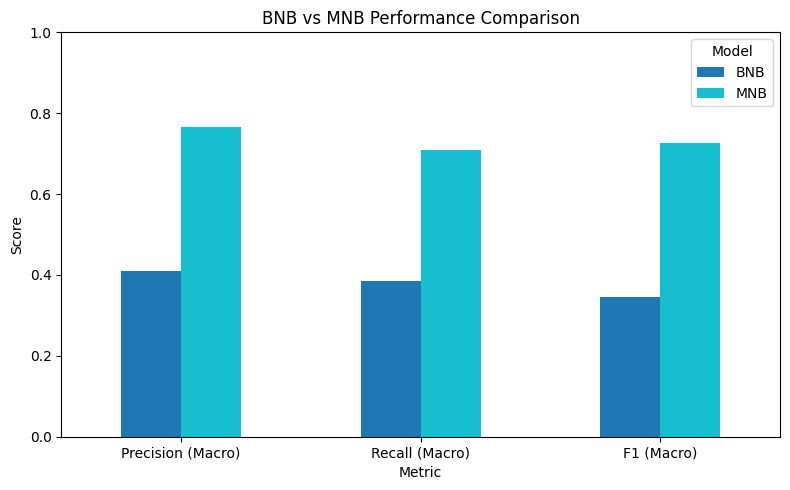

In [58]:
# draw the bar chart
results.set_index('Metric').plot(kind='bar', figsize=(8, 5), colormap='tab10')
plt.title('BNB vs MNB Performance Comparison')
plt.ylabel('Score')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

4. **choose number of features**

To get the work best value, I store different number of features in a list and loop these values to compare Macro-F1 score. As is shown below in the chart, about 500 features get the highest score. After using 500 features and retrained the two models, we can see that their performance become better. For BNB, the orignal Macro-F1 is 0.34 and now it increace to 0.55. For MNB, it increase from 0.72 to 0.85

In [59]:
# Define number of features to test
feature_counts = [100, 500, 1000, 3000, 5000, 10000]

# Store results
results = []

# Loop over N values
for n in feature_counts:
    for clf_name, clf in [('BNB', BernoulliNB()), ('MNB', MultinomialNB())]:
        pipeline = Pipeline([
            ('vect', CountVectorizer(max_features=n, binary=(clf_name == 'BNB'))),
            ('clf', clf)
        ])

        scores = cross_validate(
            pipeline, df['clean'], df['topic'],
            scoring={
                'f1': 'f1_macro',
                'precision': 'precision_macro',
                'recall': 'recall_macro'
            },
            cv=5,
            return_train_score=False
        )

        results.append({
            'Model': clf_name,
            'Features': n,
            'F1': scores['test_f1'].mean(),
            'Precision': scores['test_precision'].mean(),
            'Recall': scores['test_recall'].mean()
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

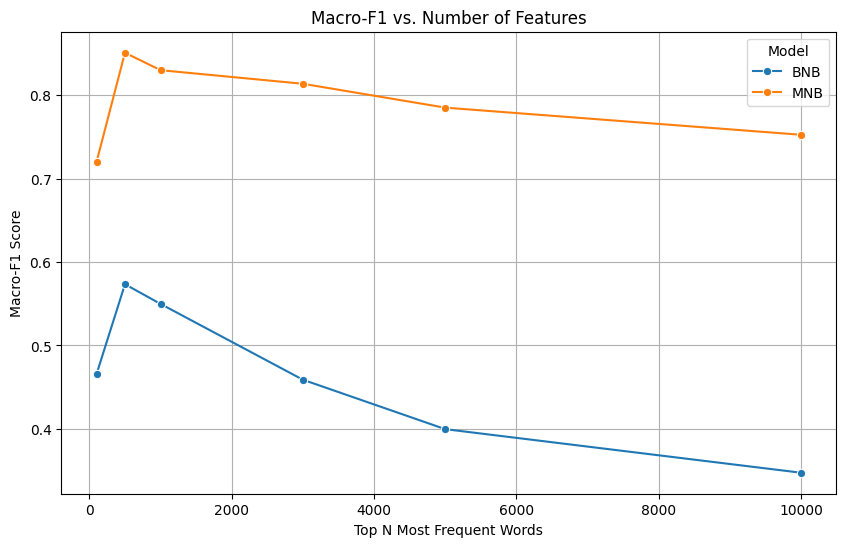

In [60]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Features', y='F1', hue='Model', marker='o')
plt.title('Macro-F1 vs. Number of Features')
plt.ylabel('Macro-F1 Score')
plt.xlabel('Top N Most Frequent Words')
plt.grid(True)
plt.show()


In [61]:
# use 500 features
vectorizer = CountVectorizer(max_features=500)
X = vectorizer.fit_transform(df['clean'])


              Metric       BNB       MNB
0  Precision (Macro)  0.562652  0.868476
1     Recall (Macro)  0.553637  0.844762
2         F1 (Macro)  0.552392  0.854770


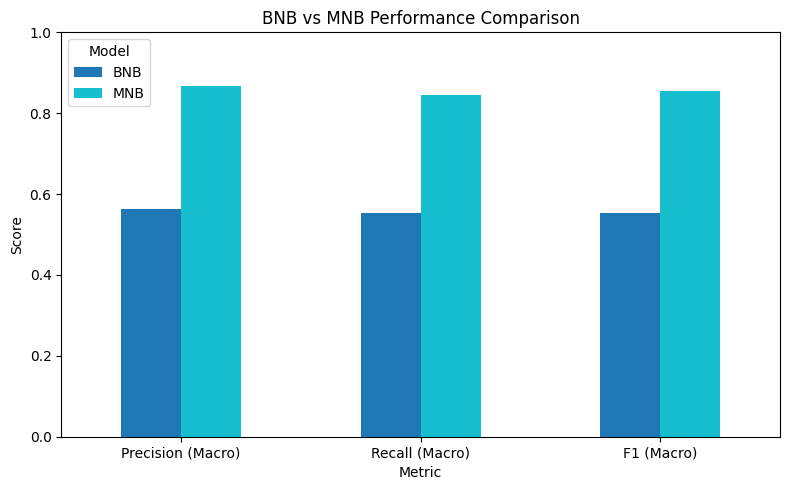

In [62]:
# show the result of use 500 features
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

bnb = BernoulliNB()
mnb = MultinomialNB()

bnb_scores = cross_validate(bnb, X, y, cv=cv, scoring=scoring)
mnb_scores = cross_validate(mnb, X, y, cv=cv, scoring=scoring)

results = pd.DataFrame({
    'Metric': ['Precision (Macro)', 'Recall (Macro)', 'F1 (Macro)'],
    'BNB': [

        bnb_scores['test_macro_precision'].mean(),
        bnb_scores['test_macro_recall'].mean(),
        bnb_scores['test_macro_f1'].mean()
    ],
    'MNB': [

        mnb_scores['test_macro_precision'].mean(),
        mnb_scores['test_macro_recall'].mean(),
        mnb_scores['test_macro_f1'].mean()
    ]
})

print(results)

results.set_index('Metric').plot(kind='bar', figsize=(8, 5), colormap='tab10')
plt.title('BNB vs MNB Performance Comparison')
plt.ylabel('Score')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

5. **machine learning method choosing**

I choose logic regression for train on this dataset.

Logistic Regression is a statistical learning method widely used in classification tasks. It maps the linear regression output to the [0,1] interval through the Sigmoid function, indicating the probability.

Text features are usually linearly separable and medium-scale data (1500 songs) is suitable for the sample requirements of logistic regression. Logistic Regression has probability output that can be directly used for recommendation sorting. This model will have higher accuracy than MNB and BNB.


              Metric       BNB       MNB  LogisticRegression
0  Precision (Macro)  0.562652  0.868476            0.874827
1     Recall (Macro)  0.553637  0.844762            0.861684
2         F1 (Macro)  0.552392  0.854770            0.865383


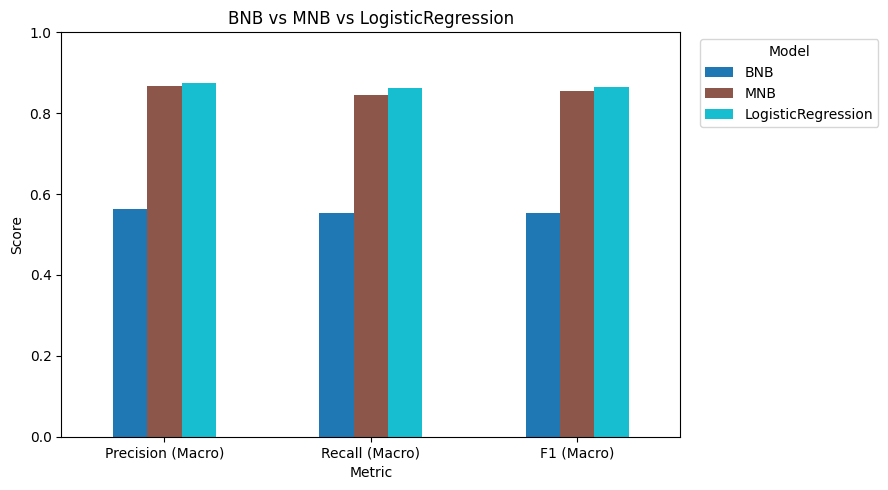

In [63]:
# Train Logistic Regression
logreg = LogisticRegression(
    class_weight='balanced',   # handle imbalanced dataset
    max_iter=1000,
    solver='liblinear',        # good for small-to-medium datasets
    random_state=42
)

# Perform cross-validation
logreg_scores = cross_validate(
    logreg, X, y, cv=cv,
    scoring={
        'macro_precision': 'precision_macro',
        'macro_recall': 'recall_macro',
        'macro_f1': 'f1_macro'
    }
)

# Add results to DataFrame
results['LogisticRegression'] = [
    logreg_scores['test_macro_precision'].mean(),
    logreg_scores['test_macro_recall'].mean(),
    logreg_scores['test_macro_f1'].mean()
]

print(results)

# Plot updated results


results.set_index('Metric').plot(kind='bar', figsize=(9, 5), colormap='tab10')

plt.title('BNB vs MNB vs LogisticRegression')
plt.ylabel('Score')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=0)


plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1.02, 1.0))

plt.tight_layout()
plt.show()


**Part2**

1. I choose logic regression model to classify the dataset in part2. Firstly, split the dataset into train_df(week1-3) and test_df(week4). Secondly, train the model to get the predict topic. Then collect usrs' keywords and mark if usrs like the songs, build usr profile accrding to tf-idf matrix. Finaly print the top 20 keywords of each topic they liked.


In [64]:
train_df = df.iloc[:750].copy()
test_df = df.iloc[750:1000].copy()
print(train_df.head())


                            artist_name         track_name release_date  \
0                                loving  the not real lake         1970   
1                               incubus    into the summer         1970   
2                             reignwolf           hardcore         1970   
3                  tedeschi trucks band             anyhow         1970   
4  lukas nelson and promise of the real  if i started over         1970   

   genre                                             lyrics      topic  \
0   rock  awake know go see time clear world mirror worl...       dark   
1   rock  shouldn summer pretty build spill ready overfl...  lifestyle   
2  blues  lose deep catch breath think say try break wal...    sadness   
3  blues  run bitter taste take rest feel anchor soul pl...    sadness   
4  blues  think think different set apart sober mind sym...       dark   

                                            all_text  \
0  loving the not real lake 1970 rock awake know

In [65]:
# Train on training set
X_train = vectorizer.transform(train_df['clean'])
y_train = train_df['topic']

logreg.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')

In [67]:
# Predict for training data to simulate user profile building
train_df['pred_topic'] = logreg.predict(X_train)

# Predict for test data
X_test = vectorizer.transform(test_df['clean'])
test_df['pred_topic'] = logreg.predict(X_test)

In [68]:
# store usr keywords from user1.tsv, user2.tsv, user3.tsv
def load_user_keywords(filename):
    user_keywords = {}
    with open(filename, 'r') as f:
        for line in f:
            topic, keywords = line.strip().split('\t')
            words = keywords.lower().split(',')
            keywords = []
            for w in words:
                w = re.sub(r'[^\w\s]', '', w)
                w = w.strip()
                keywords.append(w)

            user_keywords[topic.lower()] = set(keywords)
    return user_keywords

user1_kw = load_user_keywords("user1.tsv")
user2_kw = load_user_keywords("user2.tsv")
user3_kw = load_user_keywords("user3.tsv")
print(user1_kw)
print(user2_kw)
print(user3_kw)

{'topic': {'keywords'}, 'dark': {'enemy', 'storm', 'fire', 'fight', 'pain'}, 'sadness': {'cry', 'heartbroken', 'tears', 'alone', 'regret'}, 'personal': {'growth', 'identity', 'truth', 'life', 'dream'}, 'lifestyle': {'night', 'city', 'party', 'light', 'rhythm'}, 'emotion': {'hug', 'feel', 'kiss', 'love', 'memory'}}
{'topic': {'keywords'}, 'sadness': {'lost', 'goodbye', 'silence', 'sorrow', 'tears'}, 'emotion': {'kiss', 'feeling', 'romance', 'touch', 'memory'}}
{'topic': {'keywords'}, 'sadness': {'broken', 'blame', 'leave'}, 'lifestyle': {'beach', 'wind', 'sky', 'party', 'sing', 'rain', 'sunshine'}, 'emotion': {'miss', 'excited', 'happy', 'said', 'enjoy'}}


In [69]:
# the column contains value true or false, true: the song is liked by user, false otherwise.
def is_liked_by_user(row, user_keywords):
    topic = row['pred_topic'].lower()
    if topic not in user_keywords:
        return False
    song_words = set(row['clean'].split())
    return not song_words.isdisjoint(user_keywords[topic])

train_df['liked_by_user1'] = train_df.apply(lambda row: is_liked_by_user(row, user1_kw), axis=1)
train_df['liked_by_user2'] = train_df.apply(lambda row: is_liked_by_user(row, user2_kw), axis=1)
train_df['liked_by_user3'] = train_df.apply(lambda row: is_liked_by_user(row, user3_kw), axis=1)
print(train_df['liked_by_user1'])


0       True
1      False
2      False
3      False
4      False
       ...  
745     True
746     True
747    False
748    False
749     True
Name: liked_by_user1, Length: 750, dtype: bool


In [70]:
# Keeps only alphabetic words with 3+ characters
tfidf = TfidfVectorizer(
    max_features=5000,
    token_pattern=r'(?u)\b[a-zA-Z]{3,}\b'
)
tfidf_matrix = tfidf.fit_transform(train_df['clean'])
tfidf_matrix_test = tfidf.transform(test_df['clean'])


In [71]:
# use tf-idf values to define user profiles
def build_user_profiles(df, tfidf_matrix, user_col):
    user_profiles = {}
    for topic in df['pred_topic'].unique():
        indices = df[(df['pred_topic'] == topic) & (df[user_col])].index
        if len(indices) == 0:
            continue
        else:

            profile_vec = np.asarray(tfidf_matrix[indices].mean(axis=0))

            user_profiles[topic] = normalize(profile_vec)
    return user_profiles

user1_profiles = build_user_profiles(train_df, tfidf_matrix, 'liked_by_user1')
user2_profiles = build_user_profiles(train_df, tfidf_matrix, 'liked_by_user2')
user3_profiles = build_user_profiles(train_df, tfidf_matrix, 'liked_by_user3')
print(user3_profiles)

{'lifestyle': array([[0., 0., 0., ..., 0., 0., 0.]]), 'sadness': array([[0., 0., 0., ..., 0., 0., 0.]]), 'emotion': array([[0., 0., 0., ..., 0., 0., 0.]])}


In [72]:
# print top 20 words in each topic users liked

def print_top_words(user_profile, vectorizer, top_n=20):
    feature_names = np.array(vectorizer.get_feature_names_out())
    for topic, vec in user_profile.items():
        print(f"\n Top {top_n} words for topic '{topic}'")
        scores = np.array(vec).flatten()
        top_indices = scores.argsort()[::-1][:top_n]
        top_words = feature_names[top_indices]
        print(", ".join(top_words))

print_top_words(user1_profiles, tfidf)
print_top_words(user2_profiles, tfidf)
print_top_words(user3_profiles, tfidf)



 Top 20 words for topic 'dark'
fight, black, know, stand, like, kill, blood, hand, gon, come, rise, head, tell, death, wall, high, shoot, grind, follow, time

 Top 20 words for topic 'lifestyle'
night, sing, song, long, time, right, home, wait, come, play, tonight, mind, make, late, know, blue, want, like, closer, tire

 Top 20 words for topic 'sadness'
cry, tear, steal, mean, know, smile, club, baby, regret, great, think, face, blame, stay, write, place, fear, eye, soul, dyin

 Top 20 words for topic 'emotion'
good, feel, hold, touch, morning, kiss, love, know, miss, lip, soft, want, luck, baby, vibe, feelin, heart, sunrise, video, nice

 Top 20 words for topic 'personal'
life, live, world, dream, change, know, time, thing, wan, think, learn, thank, like, come, want, believe, good, forever, gon, people

 Top 20 words for topic 'sadness'
heart, break, away, fade, inside, tear, scar, blame, smile, rainwater, fall, hard, laughter, come, open, magnify, like, goodbye, step, wan

 Top 20 w

2. I choose N songs per topic because this can ensure recommand songs come from every topics user liked.

The metrics are precision, recall and F1.

precision: show the accuracy of recommendation.

recall: show comprehensive of recommender.

F1: balances both precision and recall.

the recommend_top_n_per_topic function calculate similarity between the user's profile and each song using similarity function (cosine, euclidean, or Jaccard). The evaluate_recommendations function is used to evaluate the performance of this recommender by showing the score of precision, recall and F1. The recommendation for user1 is the most accurate because the profile contains the most types of songs.

I tried three similarity functions cosine, jaccard and euclidean and the output below shows the score of each recommendation. Cosine and jaccard get the same score, jaccard performs better on the profile of user2 and user3 which contain less types of topics. For user1 the score of jaccard is slightly lower than cosine and euclidean. So finally I choose jaccard similarity for recommender. In order to get balanced performance, I choose N = 10 and M = 50.



In [74]:
# return N songs recommend to user
def recommend_top_n_per_topic(user_profile, tfidf_test, test_df, vectorizer, N=5, M=None, similarity_func=cosine_similarity):
    recommendations = []
    feature_names = np.array(vectorizer.get_feature_names_out())

    for topic, user_vec in user_profile.items():
        topic_indices = np.where(test_df['pred_topic'] == topic)[0]
        if len(topic_indices) == 0:
            continue

        topic_matrix = tfidf_test[topic_indices]

        # Select top-M words if requested
        scores = np.asarray(user_vec).flatten()
        if M is not None:
            top_m_idx = scores.argsort()[::-1][:M]
        else:
            top_m_idx = np.where(scores > 0)[0]

        # Handle set-based similarity functions
        if similarity_func.__name__ in {'jaccard_similarity'}:
            user_word_set = set(feature_names[top_m_idx])
            sims = []

            for idx in topic_indices:
                song_vec = tfidf_test[idx]
                song_scores = np.asarray(song_vec.toarray()).flatten()
                song_word_idx = np.where(song_scores > 0)[0]
                song_word_set = set(feature_names[song_word_idx])

                sim = similarity_func(user_word_set, song_word_set)
                sims.append(sim)

        else:
            # Vector-based similarity
            reduced_vec = np.zeros(user_vec.shape)
            reduced_vec[0, top_m_idx] = scores[top_m_idx]
            profile_vec = reduced_vec if M is not None else user_vec

            sims = similarity_func(profile_vec, topic_matrix)[0]

        top_n_idx = np.argsort(sims)[::-1][:N]
        top_song_indices = topic_indices[top_n_idx]
        recommendations.extend(top_song_indices)

    return recommendations



In [75]:
def euclidean_similarity(x, y):
    return 1 / (1 + euclidean_distances(x, y))


def jaccard_similarity(set1, set2):
    intersection = set1 & set2
    union = set1 | set2
    return len(intersection) / len(union) if union else 0


In [76]:
# the function to evaluate the performance of recommendation
def evaluate_recommendations(recommended_indices, test_df, user_keywords):
    liked = []
    for idx in recommended_indices:
        row = test_df.iloc[idx]
        topic = row['pred_topic']
        if topic in user_keywords:
            song_words = set(row['clean'].split())
            if not song_words.isdisjoint(user_keywords[topic]):
                liked.append(1)
            else:
                liked.append(0)
        else:
            liked.append(0)

    liked = np.array(liked)
    precision = liked.mean()

    # Compute recall
    relevant_total = test_df.apply(
        lambda row: row['pred_topic'] in user_keywords and
                    not set(row['clean'].split()).isdisjoint(user_keywords[row['pred_topic']]),
        axis=1
    ).sum()
    recall = liked.sum() / relevant_total if relevant_total > 0 else 0

    f1 = 2 * precision * recall / (precision + recall + 1e-10)
    return precision, recall, f1


In [77]:
M_values = [None, 100, 50]
users = {
    'User1': (user1_profiles, user1_kw),
    'User2': (user2_profiles, user2_kw),
    'User3': (user3_profiles, user3_kw),
}
print('Using Jaccard similarity')
# show the score use different value of M
for M in M_values:
    print(f"\n--- M = {'All' if M is None else M} ---")
    for name, (profiles, keywords) in users.items():
        rec = recommend_top_n_per_topic(
            profiles, tfidf_matrix_test, test_df, tfidf, N=10, M=M, similarity_func=jaccard_similarity
        )
        p, r, f = evaluate_recommendations(rec, test_df, keywords)
        print(f"{name}: Precision = {p:.2f}, Recall = {r:.2f}, F1 = {f:.2f}")



Using Jaccard similarity

--- M = All ---
User1: Precision = 0.62, Recall = 0.35, F1 = 0.45
User2: Precision = 0.30, Recall = 0.60, F1 = 0.40
User3: Precision = 0.40, Recall = 0.35, F1 = 0.37

--- M = 100 ---
User1: Precision = 0.70, Recall = 0.39, F1 = 0.50
User2: Precision = 0.25, Recall = 0.50, F1 = 0.33
User3: Precision = 0.47, Recall = 0.41, F1 = 0.44

--- M = 50 ---
User1: Precision = 0.72, Recall = 0.40, F1 = 0.52
User2: Precision = 0.20, Recall = 0.40, F1 = 0.27
User3: Precision = 0.40, Recall = 0.35, F1 = 0.37


In [78]:
M_values = [None, 100, 50]
users = {
    'User1': (user1_profiles, user1_kw),
    'User2': (user2_profiles, user2_kw),
    'User3': (user3_profiles, user3_kw),
}
print('Using euclidean similarity')

for M in M_values:
    print(f"\n--- M = {'All' if M is None else M} ---")
    for name, (profiles, keywords) in users.items():
        rec = recommend_top_n_per_topic(
            profiles, tfidf_matrix_test, test_df, tfidf, N=10, M=M, similarity_func=euclidean_similarity
        )
        p, r, f = evaluate_recommendations(rec, test_df, keywords)
        print(f"{name}: Precision = {p:.2f}, Recall = {r:.2f}, F1 = {f:.2f}")

Using euclidean similarity

--- M = All ---
User1: Precision = 0.72, Recall = 0.40, F1 = 0.52
User2: Precision = 0.15, Recall = 0.30, F1 = 0.20
User3: Precision = 0.40, Recall = 0.35, F1 = 0.37

--- M = 100 ---
User1: Precision = 0.70, Recall = 0.39, F1 = 0.50
User2: Precision = 0.15, Recall = 0.30, F1 = 0.20
User3: Precision = 0.43, Recall = 0.38, F1 = 0.41

--- M = 50 ---
User1: Precision = 0.72, Recall = 0.40, F1 = 0.52
User2: Precision = 0.15, Recall = 0.30, F1 = 0.20
User3: Precision = 0.43, Recall = 0.38, F1 = 0.41


In [79]:
M_values = [None, 100, 50]
users = {
    'User1': (user1_profiles, user1_kw),
    'User2': (user2_profiles, user2_kw),
    'User3': (user3_profiles, user3_kw),
}
print('Using cosine similarity')

for M in M_values:
    print(f"\n--- M = {'All' if M is None else M} ---")
    for name, (profiles, keywords) in users.items():
        rec = recommend_top_n_per_topic(
            profiles, tfidf_matrix_test, test_df, tfidf, N=10, M=M, similarity_func=cosine_similarity
        )
        p, r, f = evaluate_recommendations(rec, test_df, keywords)
        print(f"{name}: Precision = {p:.2f}, Recall = {r:.2f}, F1 = {f:.2f}")

Using cosine similarity

--- M = All ---
User1: Precision = 0.72, Recall = 0.40, F1 = 0.52
User2: Precision = 0.15, Recall = 0.30, F1 = 0.20
User3: Precision = 0.40, Recall = 0.35, F1 = 0.37

--- M = 100 ---
User1: Precision = 0.70, Recall = 0.39, F1 = 0.50
User2: Precision = 0.15, Recall = 0.30, F1 = 0.20
User3: Precision = 0.43, Recall = 0.38, F1 = 0.41

--- M = 50 ---
User1: Precision = 0.72, Recall = 0.40, F1 = 0.52
User2: Precision = 0.15, Recall = 0.30, F1 = 0.20
User3: Precision = 0.43, Recall = 0.38, F1 = 0.41



=== N = 3 ===
--- M = 50 ---
User1: Precision = 0.93, Recall = 0.16, F1 = 0.27
User2: Precision = 0.33, Recall = 0.20, F1 = 0.25
User3: Precision = 0.56, Recall = 0.15, F1 = 0.23

=== N = 5 ===
--- M = 50 ---
User1: Precision = 0.84, Recall = 0.24, F1 = 0.37
User2: Precision = 0.30, Recall = 0.30, F1 = 0.30
User3: Precision = 0.60, Recall = 0.26, F1 = 0.37

=== N = 10 ===
--- M = 50 ---
User1: Precision = 0.72, Recall = 0.40, F1 = 0.52
User2: Precision = 0.20, Recall = 0.40, F1 = 0.27
User3: Precision = 0.40, Recall = 0.35, F1 = 0.37

=== N = 15 ===
--- M = 50 ---
User1: Precision = 0.59, Recall = 0.49, F1 = 0.54
User2: Precision = 0.17, Recall = 0.50, F1 = 0.25
User3: Precision = 0.33, Recall = 0.44, F1 = 0.38


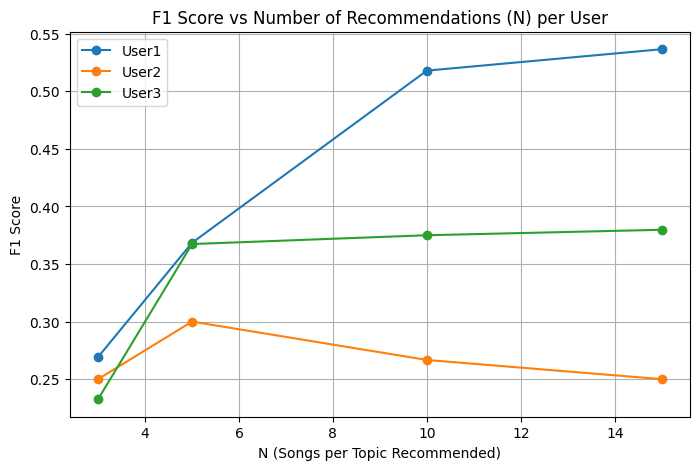

In [81]:
# show the score use different N value with same M = 50
N_values = [3, 5, 10, 15]
M_values = [50]
users = {
    'User1': (user1_profiles, user1_kw),
    'User2': (user2_profiles, user2_kw),
    'User3': (user3_profiles, user3_kw),
}

results = []

for N in N_values:
    print(f"\n=== N = {N} ===")
    for M in M_values:
        print(f"--- M = {M} ---")
        for name, (profiles, keywords) in users.items():
            rec = recommend_top_n_per_topic(
                profiles, tfidf_matrix_test, test_df, tfidf, N=N, M=M, similarity_func=jaccard_similarity
            )
            p, r, f = evaluate_recommendations(rec, test_df, keywords)
            print(f"{name}: Precision = {p:.2f}, Recall = {r:.2f}, F1 = {f:.2f}")
            results.append({
                'User': name,
                'N': N,
                'M': M,
                'Precision': p,
                'Recall': r,
                'F1': f
            })

# Convert to DataFrame for plotting
score_df = pd.DataFrame(results)

# Plot F1-score vs N for each user (M fixed at 50)
plt.figure(figsize=(8, 5))
for user in score_df['User'].unique():
    subset = score_df[score_df['User'] == user]
    plt.plot(subset['N'], subset['F1'], marker='o', label=user)

plt.xlabel('N (Songs per Topic Recommended)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Number of Recommendations (N) per User')
plt.legend()
plt.grid(True)
plt.show()


**part3**

For week1, 2, 3, 10 random choosen song is shown to user, and she select the song she liked. Then I use the same method in part2, use logic regression to predict the topic and use these user liked songs to build user profile, then use jaccard similarity function to recommend songs and show these songs to user. User picked the songs they like from week4, then I evaluate the outcome.

From the bar chart below we can notice that compare with the recommendation accuracy for user1, user2 and user3, this accuracy for real user is much lower, this is because when real users choose their favorite songs, they don’t just focus on whether the lyrics contain the keywords they are interested in or the type of song, but also pay attention to the melody and singer of the song. Just use text to predict the type of the song is not satisfactory. In addition， only three random selections will result in insufficient samples, which is why the recommendation accuracy is low.

To improve the recommendation accuracy for real user, I think I should get more feedback from user, build better representation of their preferences and filter more comprehensive expression of the characteristics of the song.


In [86]:
# random select songs from week1, 2, 3
random.seed(42)
def week_batch(df, start_idx, end_idx, N):
    return df.iloc[random.sample(range(start_idx, end_idx), N)]

week1_df = week_batch(df, 0, 249, 10)
week2_df = week_batch(df, 250, 499, 10)
week3_df = week_batch(df, 500, 749, 10)
week4_df = df.iloc[750:1000].copy()
print('week1:', week1_df)


week1:          artist_name                   track_name release_date    genre  \
163          skillet                       anchor         1970     rock   
28   imagine dragons             walking the wire         1970     rock   
6         rebelution                    trap door         1970   reggae   
189     andy grammer                wish you pain         1970     rock   
70   scotty mccreery                   this is it         1970  country   
62      jd mcpherson               desperate love         1970    blues   
57      gregg allman             going going gone         1970    blues   
35     george strait                 take me away         1970  country   
188     the movement                 cool me down         1970   reggae   
26       nappy roots  these walls (dirty mc edit)         1970  hip hop   

                                                lyrics     topic  \
163  driftin beneath horizon body weak tryin shore ...      dark   
28   feel away oohoh oohoh know

In [95]:
# collect songs user liked
user_likes = {
    1: [189, 57, 28, 70],  # Week 1 liked indices
    2: [423, 389, 257, 401],  # Week 2
    3: [555, 559, 550, 679]   # Week 3
}

week4_df = df.iloc[750:1000].copy().reset_index(drop=True)
tfidf_week4 = tfidf.transform(week4_df['clean'])

week1_df['pred_topic'] = logreg.predict(vectorizer.transform(week1_df['clean']))
week2_df['pred_topic'] = logreg.predict(vectorizer.transform(week2_df['clean']))
week3_df['pred_topic'] = logreg.predict(vectorizer.transform(week3_df['clean']))
week4_df['pred_topic'] = logreg.predict(vectorizer.transform(week4_df['clean']))

/tmp/ipython-input-95-2706008413.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week1_df['pred_topic'] = logreg.predict(vectorizer.transform(week1_df['clean']))
/tmp/ipython-input-95-2706008413.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week2_df['pred_topic'] = logreg.predict(vectorizer.transform(week2_df['clean']))
/tmp/ipython-input-95-2706008413.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [88]:
# Combine user interaction
interacted_df = pd.concat([week1_df, week2_df, week3_df])
interacted_df['liked_by_user'] = interacted_df.index.isin(
    user_likes[1] + user_likes[2] + user_likes[3]
)


# build user profile
user_profile = build_user_profiles(interacted_df, tfidf_matrix, 'liked_by_user')


recommended_indices = recommend_top_n_per_topic(
    user_profile, tfidf_week4, week4_df, tfidf, N=10, M=50, similarity_func=jaccard_similarity
)

# get recommend song list
print("Recommended songs for Week 4 (Please indicate which ones you like):\n")
for i, idx in enumerate(recommended_indices):
    song = week4_df.iloc[idx]
    print(f"[{i}] {song['track_name']} by {song['artist_name']} (Topic: {song['pred_topic']})")
    print(f"     Lyrics: {song['clean'][:120]}...")
    print("-" * 80)




Recommended songs for Week 4 (Please indicate which ones you like):

[0] one call away by charlie puth (Topic: sadness)
     Lyrics: charlie puth one call away 1970 pop away save superman away baby need friend wan na reach matter know away save superman...
--------------------------------------------------------------------------------
[1] let you love me by rita ora (Topic: sadness)
     Lyrics: rita os let love 1970 pop stay night instead go trouble trouble think away vulnerable fault wan na stay night wan na wan...
--------------------------------------------------------------------------------
[2] insomnia by daya (Topic: sadness)
     Lyrics: daya insomnia 1970 pop cause sleep want dream wish arm wrap insomnia day tylenol work lose track time babe insomnia mind...
--------------------------------------------------------------------------------
[3] remind me to forget by kygo (Topic: sadness)
     Lyrics: kygo remind forget 1970 pop fade away stay kiss like break glass skin great l

In [89]:
user_liked_week4 = [0, 23, 21, 6, 14, 39, 19, 10, 5, 11]  # chosen manually by user

# Convert to real df indices:
user_liked_indices = week4_df.iloc[user_liked_week4].index.tolist()

In [93]:
def evaluate_recommendations_real_user(recommended_indices, user_liked_indices):
    liked = [1 if idx in user_liked_indices else 0 for idx in recommended_indices]
    liked = np.array(liked)

    # Precision
    precision = liked.mean()

    # Recall
    recall = liked.sum() / len(user_liked_indices) if user_liked_indices else 0

    # F1 Score
    f1 = 2 * precision * recall / (precision + recall + 1e-10)

    return precision, recall, f1

p, r, f1 = evaluate_recommendations_real_user(recommended_indices, user_liked_indices)
print(f"User Study Result — Precision: {p:.2f}, Recall: {r:.2f}, F1: {f1:.2f}")


User Study Result — Precision: 0.05, Recall: 0.20, F1: 0.08


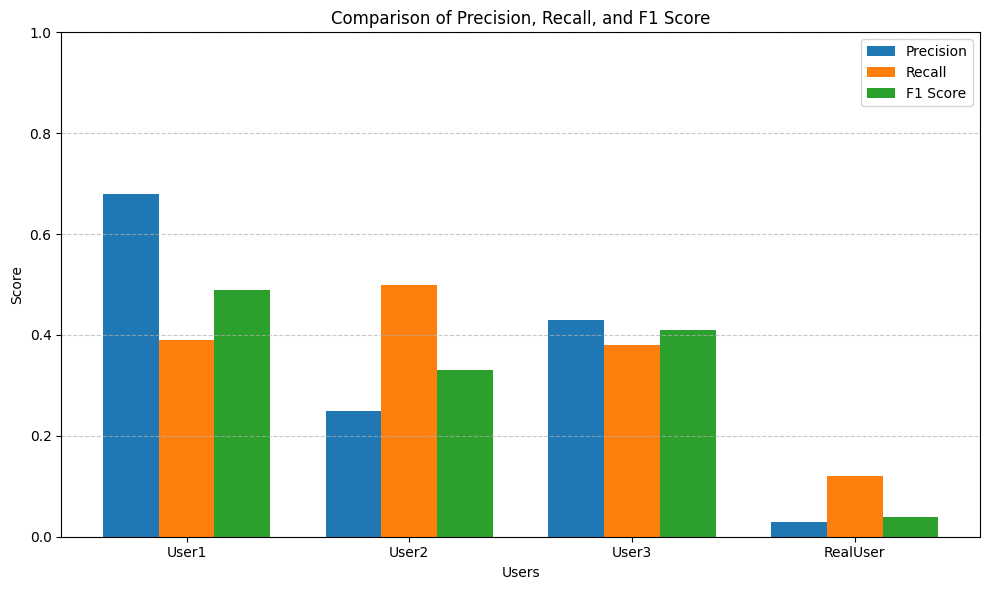

In [92]:
# Metrics for each user
users = ['User1', 'User2', 'User3', 'RealUser']
precision = [0.68, 0.25, 0.43, 0.03]
recall    = [0.39, 0.50, 0.38, 0.12]
f1        = [0.49, 0.33, 0.41, 0.04]


x = np.arange(len(users))
width = 0.25


plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')


plt.xlabel('Users')
plt.ylabel('Score')
plt.title('Comparison of Precision, Recall, and F1 Score')
plt.xticks(x, users)
plt.ylim(0, 1)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
